In [1]:
import torch
import numpy as np
import cv2
# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

In [2]:
#First load libraries and images
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode
import best.singular_point as sp

transform = transforms.Compose([
    transforms.Resize((sp.args.img_size, sp.args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.Resize((sp.args.img_size, sp.args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=60,
                                        shuffle=False, num_workers=2)

In [3]:
iterator=iter(trainloader)
img,labels = next(iterator)
print(img.shape,labels.shape)
# img = img.to(sp.device)

torch.Size([60, 1, 120, 120]) torch.Size([60])


### CustonNetDetector

In [4]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath,map_location=sp.device))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = './data/models/sp_map_fo_30.pth'
sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_siamese)

Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model loaded from ./data/models/sp_map_fo_30.pth


In [5]:
def calcular_momentos_imagem_canal(batch_tensor):
    # Obter as dimensões do batch_tensor
    B, C, H, W = batch_tensor.shape

    # Inicializar listas para armazenar os resultados
    medias = []
    maximos = []
    variancias = []
    assimetrias = []
    curtoses = []

    # Iterar sobre cada imagem do batch
    for b in range(B):
        # Iterar sobre cada canal de cor
        for c in range(C):
            # Obter a imagem atual (um canal de cor)
            imagem = batch_tensor[b, c]
            maximo = torch.max(imagem)
            # Calcular a média (primeiro momento)
            media = torch.mean(imagem)
            # Calcular a variância (segundo momento)
            variancia = torch.var(imagem)
            
            # Calcular a assimetria (terceiro momento)
            media_cubica = torch.mean((imagem - media) ** 3)
            desvio_cubico = torch.sqrt(variancia) ** 3
            assimetria = media_cubica / desvio_cubico

            # Calcular a curtose (quarto momento)
            media_quadrada = torch.mean((imagem - media) ** 4)
            curtose = media_quadrada / variancia ** 2

            # Armazenar os resultados para o canal atual
            medias.append(media.item())
            maximos.append(maximo.item())
            variancias.append(variancia.item())
            assimetrias.append(assimetria.item())
            curtoses.append(curtose.item())

    # Converter as listas para tensores
    medias = torch.tensor(medias).reshape(B, C)
    maximos = torch.tensor(maximos).reshape(B, C)
    variancias = torch.tensor(variancias).reshape(B, C)
    assimetrias = torch.tensor(assimetrias).reshape(B, C)
    curtoses = torch.tensor(curtoses).reshape(B, C)

    # Concatenar os tensores ao longo da dimensão C
    output_tensor = torch.cat((medias, maximos, variancias, assimetrias, curtoses), dim=1)

    return output_tensor


In [6]:
PS = 19

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask
 
from torch import nn
class Detector(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key_summary
        
class Detector2(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key
        

class Descriptor(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()           
           self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
           self.global_max_pool = nn.AdaptiveMaxPool2d(1)
           self.mask=torch.tensor(create_circular_mask(PS,PS)).to(sp.device)
           self.momento = calcular_momentos_imagem_canal
        def forward(self, x):
            x = x * self.mask[None][None]
            summary_pool = torch.cat([self.global_avg_pool(x).squeeze(), self.global_max_pool(x).squeeze()], dim=1)
            # summary_pool = self.momento(x)
            return summary_pool

detec = Detector(model)
detec2 = Detector2(model)
desc = Descriptor(model)

In [7]:
import torch
import kornia
from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector

device = sp.device

keynet_default_config = {
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 5, 'pyramid_levels': 1, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 22.0},
}

class CustomNetDetector(MultiResolutionDetector):
    def __init__(
        self,
        model,
        pretrained: bool = False,
        num_features: int = 60,
        keynet_conf=keynet_default_config,
        ori_module=kornia.feature.LAFOrienter(PS),
        aff_module=None,#kornia.feature.LAFAffineShapeEstimator(PS),
    ):
        super().__init__(model, num_features, keynet_conf['Detector_conf'], ori_module, aff_module)


# timg_gray = img.to(device)#timg_gray.to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = desc#sift
detector = CustomNetDetector(detec).to(device)


In [8]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            # kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
            data_keys=["input"],
            same_on_batch=True,
            # random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index to start over for circular iteration
            
        result = self.data[self.index]
        self.index += 1
        return result

params_lists =AugmentationParamsGenerator(3,img.shape)

In [9]:
def bidirectional_match(feat1, feat2, threshold=0.5):
    feat1 = feat1.float()
    feat2 = feat2.float()

    s1, matches1 = kornia.feature.match_snn(feat1, feat2, threshold)
    s2, matches2 = kornia.feature.match_snn(feat2, feat1, threshold)
    
    bidirectional_matches = []
    for i, match in enumerate(matches1):
        indices = torch.where(matches2[:, 0] == match[1].item())[0]
        if indices.numel() > 0:
            for index in indices:
                if matches2[index][1].item() == match[0].item():
                     bidirectional_matches.append((match[0].item(), match[1].item()))
    return torch.tensor(bidirectional_matches)

In [10]:
import matplotlib.pyplot as plt 
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        print('lafs ',lafs.shape,image[None].shape)
        map = detec2(image[None])
        # print('map ',map.shape,image[None].shape)
        #patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        patches = kornia.feature.extract_patches_from_pyramid(map, lafs, PS)
        B, N, CH, H, W = patches.size()
        print('patches  ',patches.shape)
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        # print('descs  ',descs.shape)
        return lafs, descs

def detect_extract_feat_in_batch(batch_img, detector, descriptor, PS):
    repo_lafs_desc = []
    with torch.no_grad():
        for image  in batch_img:            
            try:
                lafs, descs = detect_and_extract_features(image, detector, descriptor, PS)
                repo_lafs_desc.append((lafs,descs))
            except RuntimeError as e:                
                plt.imshow(kornia.tensor_to_image(image.cpu()))
                plt.show()
                result = detec(image[None])
                
                plt.imshow(kornia.tensor_to_image(result.cpu()))
                plt.show()
                
    return repo_lafs_desc

def compute_homography(lafs1, lafs2, matches):
    src_pts = lafs1[0, matches[:, 0], :, 2].data.cpu().numpy()
    dst_pts = lafs2[0, matches[:, 1], :, 2].data.cpu().numpy()
    F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 1000)
    inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]
    return inliers_mask


def matching_imagens(ref_img,batch_img, repo_lafs_desc):
    best_match_info = None
    best_match_count = 0
    best_match_index = None
    with torch.no_grad():
        # Detectar e extrair características da imagem de referência
        lafs_ref, descs_ref = detect_and_extract_features(ref_img, detector, descriptor, PS)

        for i, (lafs_i, descs_i) in enumerate(repo_lafs_desc):
            # Detectar e extrair características da imagem atual do batch
            # lafs_i, descs_i = detect_and_extract_features(img, detector, descriptor, PS)
            # Comparar as características da imagem de referência com a imagem atual do batch
            matches = bidirectional_match(descs_ref[0], descs_i[0], threshold=0.85)
            # scores, matches = kornia.feature.match_snn(descs_ref[0], descs_i[0], 0.85) # correspondencia dos descritories a uma distância de 0.9

            if matches.shape[0] >= 4:
                # Cálculo da homografia
                inliers_mask = compute_homography(lafs_ref, lafs_i, matches)
                # print(lafs_ref[0][None].shape, lafs_ref[0].shape, matches.shape, inliers_mask.shape)

                # Check if this match is better than the previous best match
                if matches.shape[0] > best_match_count:
                    best_match_info = (lafs_ref[0][None].cpu(), lafs_i[0][None].cpu(), matches.cpu(),
                                       kornia.tensor_to_image(ref_img.cpu()), kornia.tensor_to_image(batch_img[i].cpu()),
                                       inliers_mask)
                    best_match_count = matches.shape[0]
                    best_match_index = i

        if best_match_info is not None and best_match_index==0:# TODO: Remove this condition best_match_index==0
            # Plot the best match
            from kornia_moons.viz import draw_LAF_matches

            draw_LAF_matches(
                *best_match_info,
                draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
            )
        # else:
        #     print("No matches found with enough inliers.")
    return best_match_index


  0%|          | 0/17 [00:00<?, ?it/s]

lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 18, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 18, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 43, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 43, 8, 19, 19])
lafs  torch.Size([1, 18, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 18, 8, 19, 19])
lafs  torch.Size([1, 13, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 13, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 22, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size(

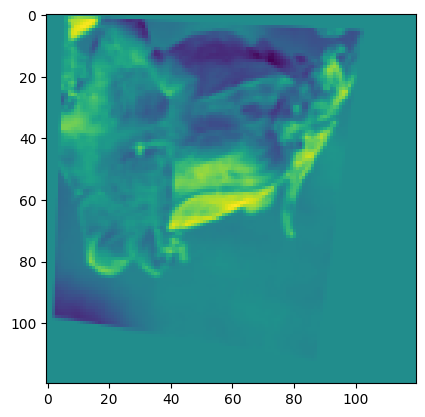

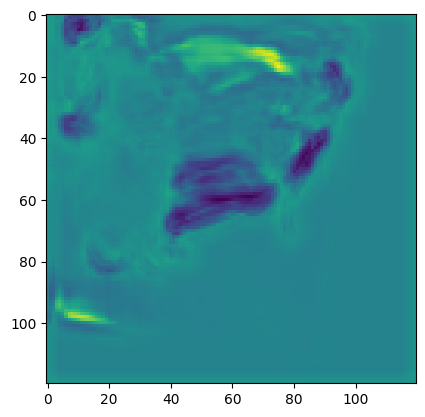

lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 6, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 6, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 4, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 4, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 6, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 6, 8, 19, 19])
lafs  torch.Size([1, 20, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 20, 8, 19, 19])
lafs  torch.Size([1, 0, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 0, 8, 19, 19])


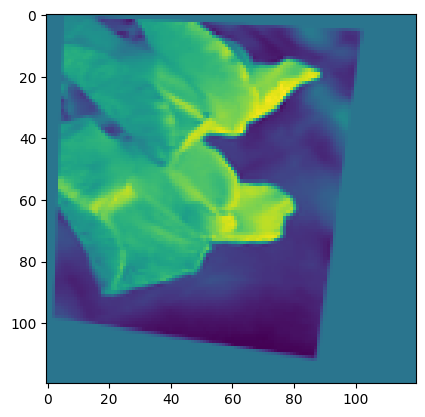

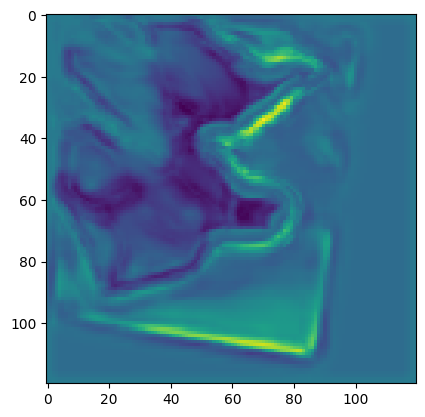

lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 19, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 19, 8, 19, 19])
lafs  torch.Size([1, 14, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 14, 8, 19, 19])
lafs  torch.Size([1, 0, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 0, 8, 19, 19])


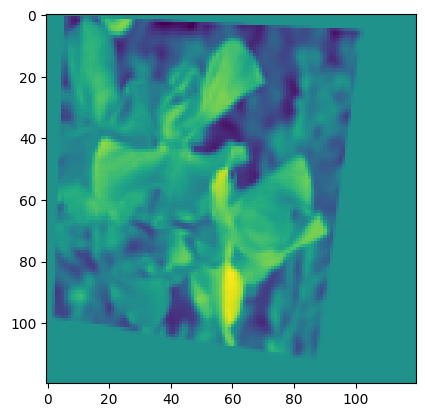

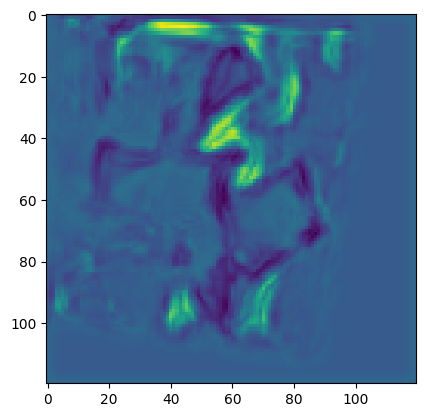

lafs  torch.Size([1, 44, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 44, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 0, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 0, 8, 19, 19])


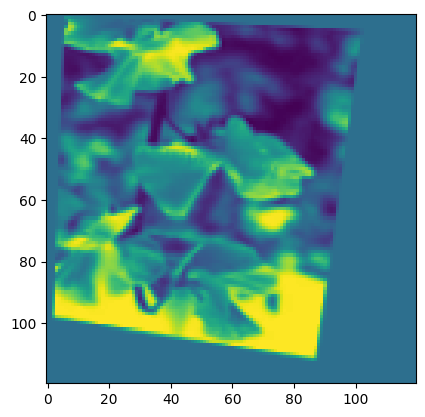

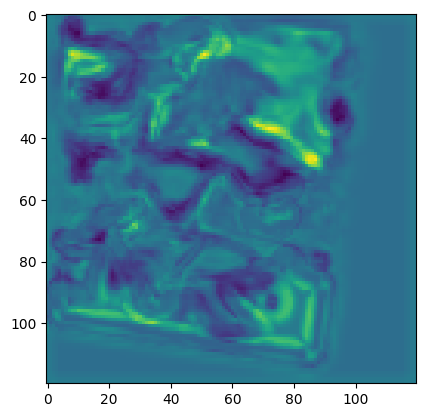

lafs  torch.Size([1, 56, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 56, 8, 19, 19])
lafs  torch.Size([1, 5, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 5, 8, 19, 19])
lafs  torch.Size([1, 33, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 33, 8, 19, 19])
lafs  torch.Size([1, 17, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 17, 8, 19, 19])
lafs  torch.Size([1, 24, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 24, 8, 19, 19])
lafs  torch.Size([1, 17, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 17, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 0, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 0, 8, 19, 19])


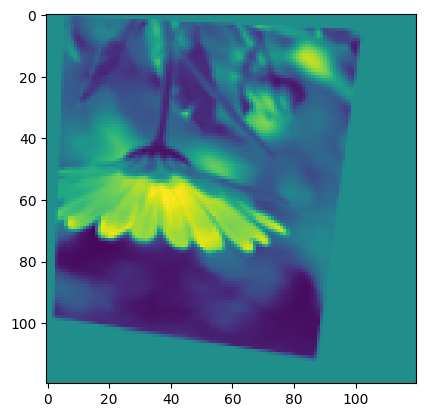

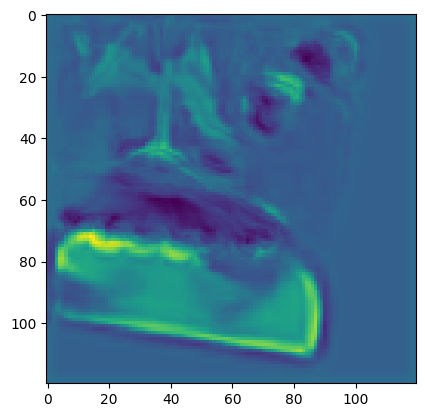

lafs  torch.Size([1, 15, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 15, 8, 19, 19])
lafs  torch.Size([1, 43, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 43, 8, 19, 19])
lafs  torch.Size([1, 60, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 19, 19])
lafs  torch.Size([1, 0, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 0, 8, 19, 19])


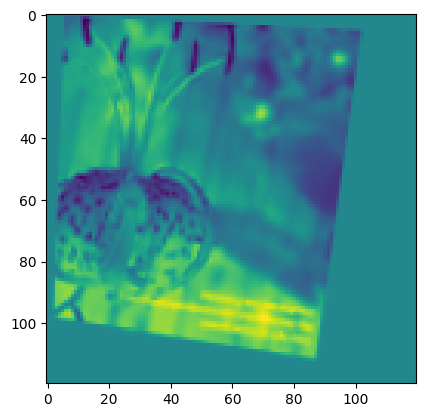

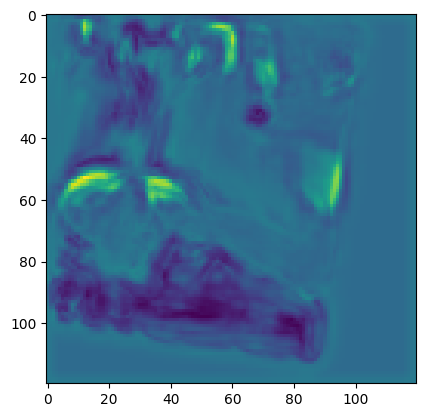

lafs  torch.Size([1, 3, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 3, 8, 19, 19])
lafs  torch.Size([1, 8, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 8, 8, 19, 19])
lafs  torch.Size([1, 4, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 4, 8, 19, 19])
lafs  torch.Size([1, 33, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 33, 8, 19, 19])
lafs  torch.Size([1, 12, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 12, 8, 19, 19])
lafs  torch.Size([1, 1, 2, 3]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 1, 8, 19, 19])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [11]:
aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
    # kornia.augmentation.RandomEqualize(p=0.3),
    data_keys=["input"],#data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
    # random_apply=15,
)

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(trainloader)
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(device)
    
    params_item = next(params_lists)
    timg_gray_t = aug_list(imgs_batch,params=params_item)
    repo_lafs_desc= detect_extract_feat_in_batch(timg_gray_t,detector,descriptor,PS)
        
    for i,img_gray in enumerate(imgs_batch):# itera em cada batch

        match_index = matching_imagens(img_gray,timg_gray_t,repo_lafs_desc)
        # print("match_index: ",match_index," i: ",i)
        total+=1
        if match_index == i:
            acertos += 1
        pbar.set_description(f"acertos/total: {acertos}/{total}  ")
print("acertos: ",acertos)